In [12]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dice_rl_TU_Vienna.value import get_get_policy_value, get_w_prod
from dice_rl_TU_Vienna.plot.continuous import get_log
from dice_rl_TU_Vienna.plugins.stable_baselines3.policy import get_model_PPO
from dice_rl_TU_Vienna.utils.general import iterate_print, merge_dicts
from dice_rl_TU_Vienna.utils.json import json_get_id
from dice_rl_TU_Vienna.utils.numpy import moving_average_N

from plugins.gymnasium.cartpole.dataset import get_probs
from plugins.gymnasium.cartpole.plot import get_logs_and_plot
from plugins.gymnasium.cartpole.config import *

/Users/richardweiss/Documents/.venvs/dice_rl_TU_Vienna/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


# Prepare

In [2]:
policy = {}
id_policy = {}

for kind in kinds:
    x, y = get_model_PPO(
        dir_base,
        env,
        {
            "seed": seed,
            "total_timesteps": total_timesteps[kind],
        },
        verbosity=1,
    )

    policy[kind] = x
    id_policy[kind] = y

get_act_behavior   = lambda obs: int( policy["behavior"]  .predict(obs)[0] )
get_act_evaluation = lambda obs: int( policy["evaluation"].predict(obs)[0] )

get_act = { "behavior": get_act_behavior, "evaluation": get_act_evaluation, }

trying to find id_policy in data/gymnasium/cartpole/policy.json
trying to load policy from data/gymnasium/cartpole/2025-02-06T12:51:54.519095/policy.zip
trying to find id_policy in data/gymnasium/cartpole/policy.json
trying to load policy from data/gymnasium/cartpole/2025-02-06T12:52:22.614772/policy.zip


In [3]:
dataset = {
    kind: pd.read_parquet( os.path.join(dir_dataset[kind], "dataset.parquet") )
        for kind in kinds
}

In [4]:
get_policy_value = {
    kind: get_get_policy_value(dataset[kind])
        for kind in kinds
}

# Selected Plots

In [25]:
logs = {}

for name in iterate_print(names, "name"):
    for gamma in iterate_print(gammas, "gamma"):

        dictionary = hyperparameters_evaluation[(gamma, name)]
        if dictionary is None: continue

        id_evaluation = json_get_id(
            file_path=os.path.join(dir_dataset["behavior"], "evaluation.json"),
            dictionary=dictionary, )
        assert id_evaluation is not None

        logs[(gamma, name)] = get_log(
            log_dir=os.path.join(dir_dataset["behavior"], id_evaluation), )

name=NeuralDualDice
gamma=0.1
gamma=0.5
gamma=0.9
name=NeuralGradientDice
gamma=0.1
gamma=0.5
gamma=0.9
name=NeuralGenDice
gamma=0.1
gamma=0.5
gamma=0.9


In [26]:
def plot(tag, baseline, gamma, suptitle, title, ylim, ylabel, ycompute, yscale):
    plt.plot()

    if baseline:
        plt.axhline(y=get_policy_value["behavior"]  (gamma), label="OnPE behavior",   color="black", linestyle="--")
        plt.axhline(y=get_policy_value["evaluation"](gamma), label="OnPE evaluation", color="black", linestyle=":")

    for name, color, marker in zip(names, colors, markers):

        x = np.array(logs[(gamma, name)]["data"][tag]["steps"])
        y = np.array(logs[(gamma, name)]["data"][tag]["values"])
        if ycompute is not None: y = ycompute(y)

        x_ma = x[n_ma-1:]
        y_ma = moving_average_N(y, n_ma)

        learning_rate = hyperparameters_evaluation[(gamma, name)]["learning_rate"]
        label = f"{name}, lr={learning_rate}"

        plt.plot(x, y, color=color, alpha=alpha)
        plt.plot(x_ma, y_ma, color=color, label=label, alpha=1, marker=marker, markevery=markevery)

    plt.ylim(ylim)

    plt.grid(linestyle=":")
    plt.legend()

    plt.xlabel("step")
    plt.ylabel(ylabel)

    if yscale == "pi":
        pi_ticks = np.arange(0, 3/16 * np.pi, 1/16 * np.pi)
        pi_labels = [r"$0$", r"$\frac{\pi}{16}$", r"$\frac{\pi}{8}$"]
        plt.yticks(pi_ticks, pi_labels)

    plt.suptitle(suptitle)
    plt.title(title)

    file_name = f"{suptitle}; {title}"
    path = os.path.join(dir_images, f"{file_name}.png")
    plt.savefig(path)

    plt.show()


def plot_pvs(weighted, gamma):
    tag = "pv_w" if weighted else "pv_s"
    baseline = True
    suptitle = "Cartpole - PVs"
    title = f"gamma={gamma}, lamda={1.0}, weighted={weighted}"
    ylim = (0, 1.25)
    ylabel = r"$\rho^\pi$"
    ycompute = None
    yscale = None
    plot(tag, baseline, gamma, suptitle, title, ylim, ylabel, ycompute, yscale)


def plot_bras(gamma):
    tag = "cos_angle"
    baseline = False
    suptitle = "Cartpole - BRAs"
    title = f"gamma={gamma}, lamda={1.0}"
    ylim = None
    ylabel = r"$\measuredangle ( \nabla P^\pi v, \nabla v )$"
    ycompute = np.arccos
    yscale = "pi"
    plot(tag, baseline, gamma, suptitle, title, ylim, ylabel, ycompute, yscale)

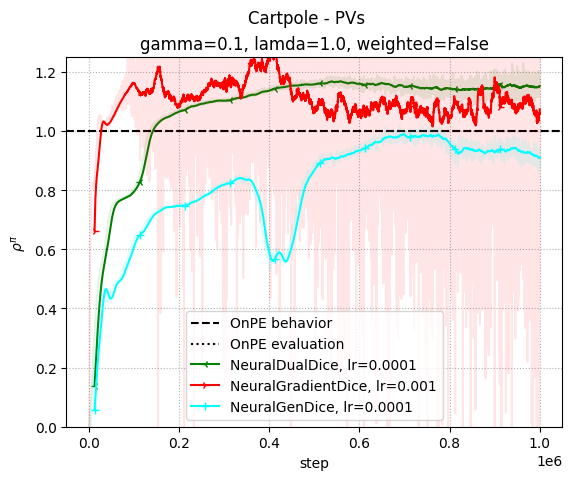

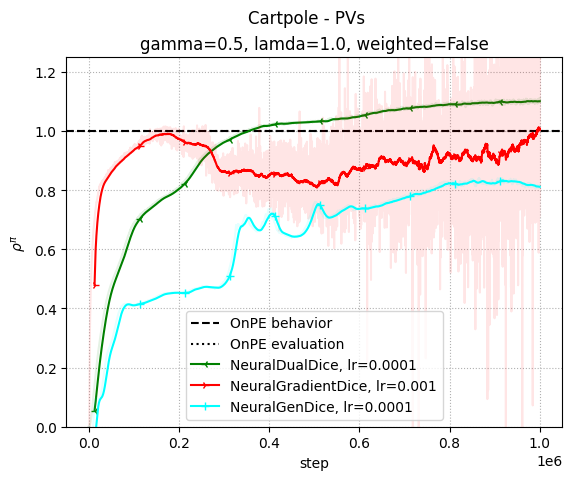

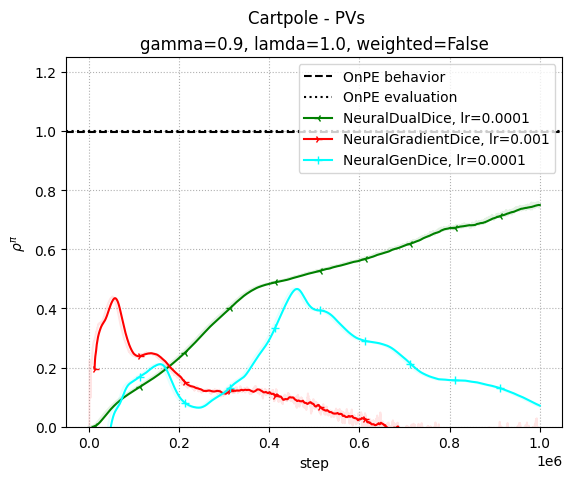

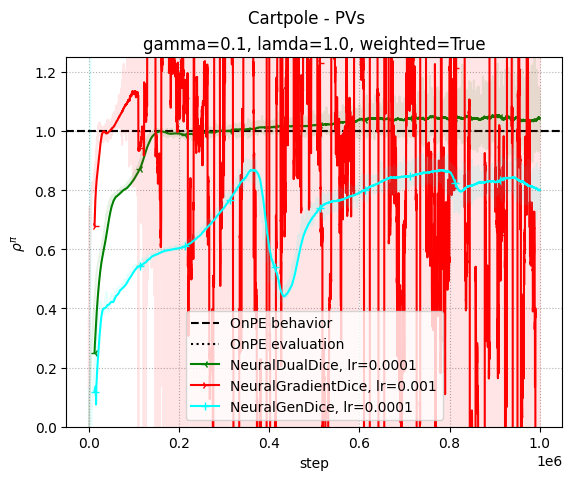

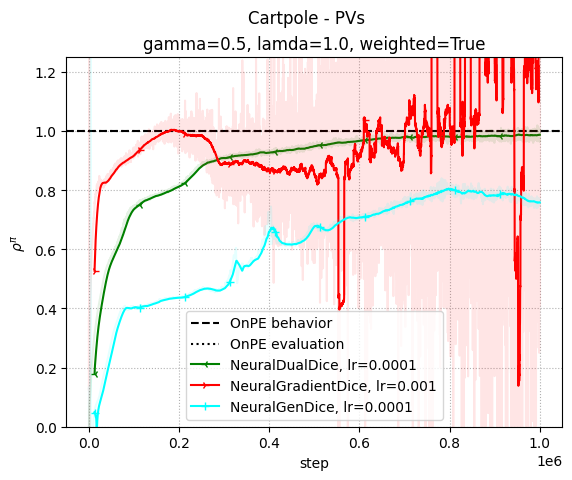

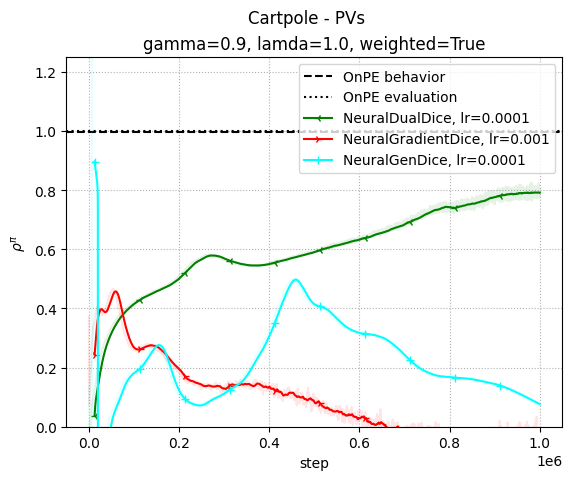

In [27]:
for weighted in [False, True]:
    for gamma in gammas:
        plot_pvs(weighted, gamma)

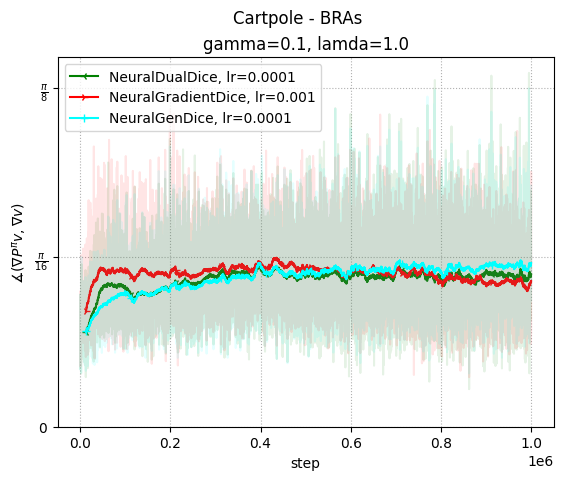

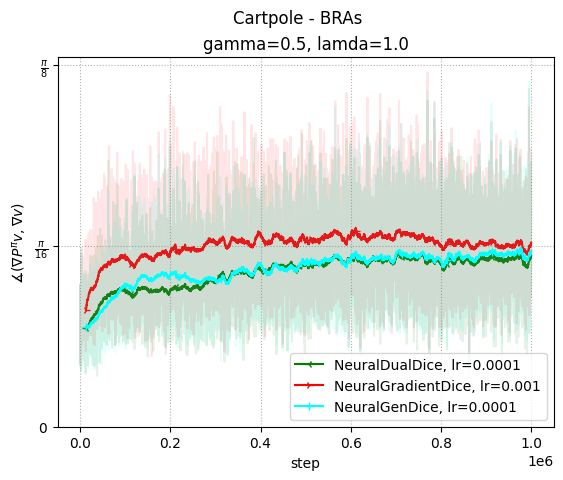

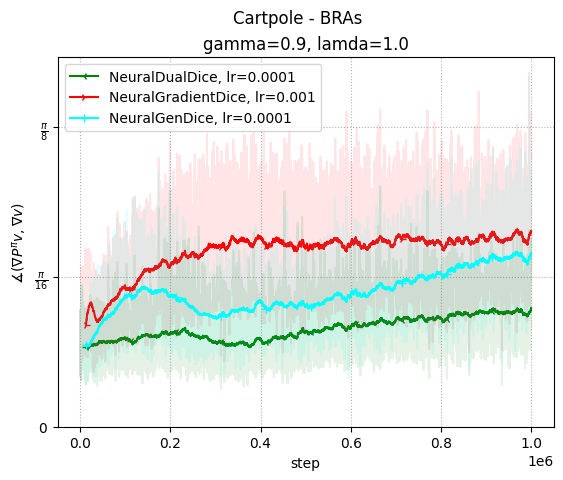

In [28]:
for gamma in gammas:
    plot_bras(gamma)

# All Plots

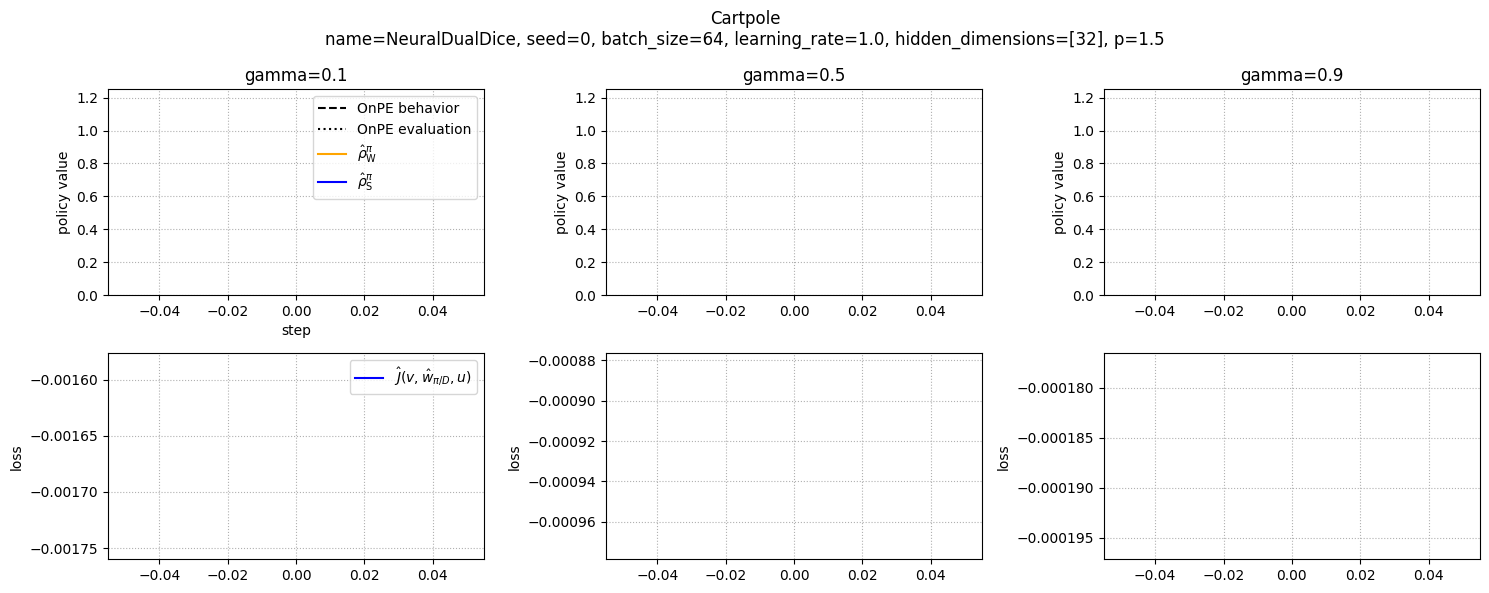

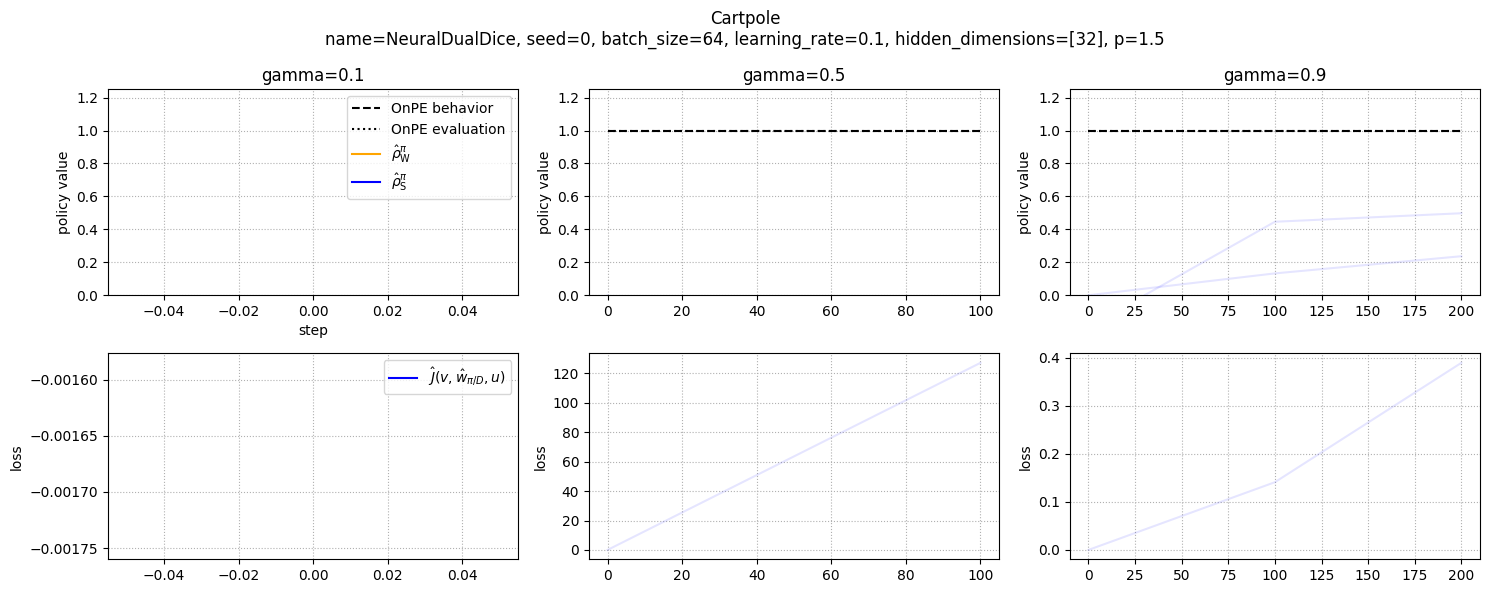

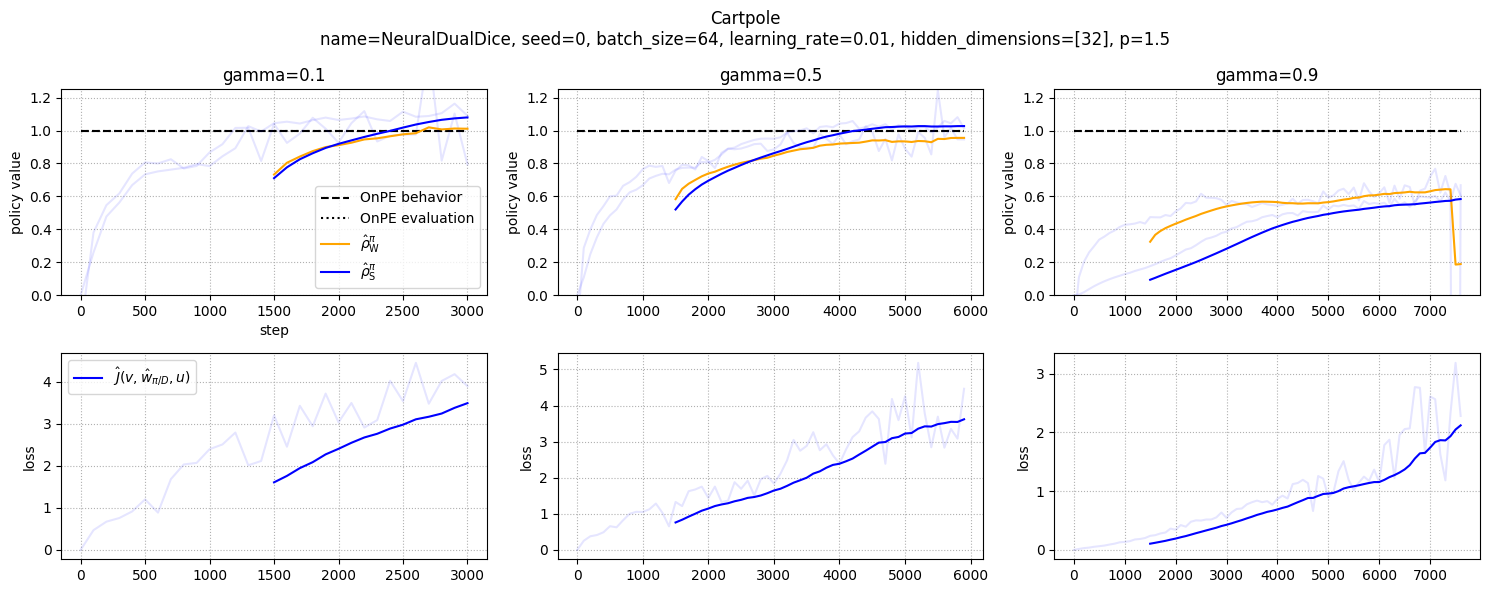

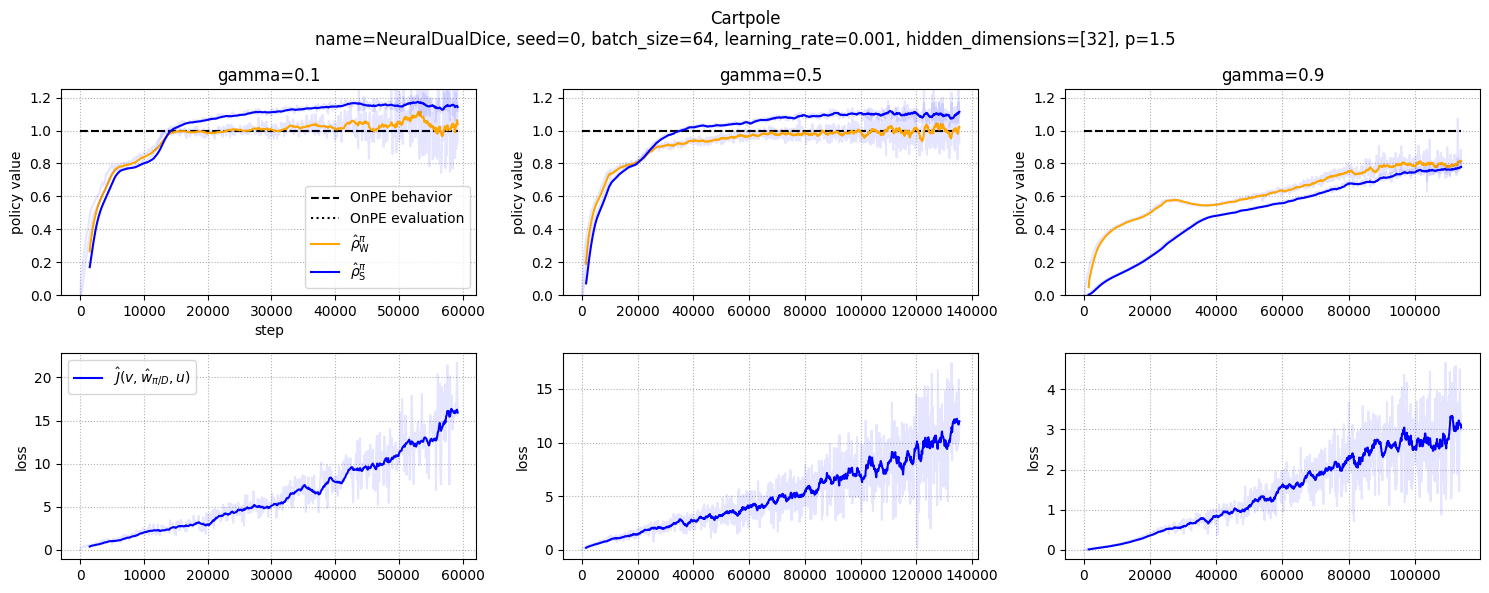

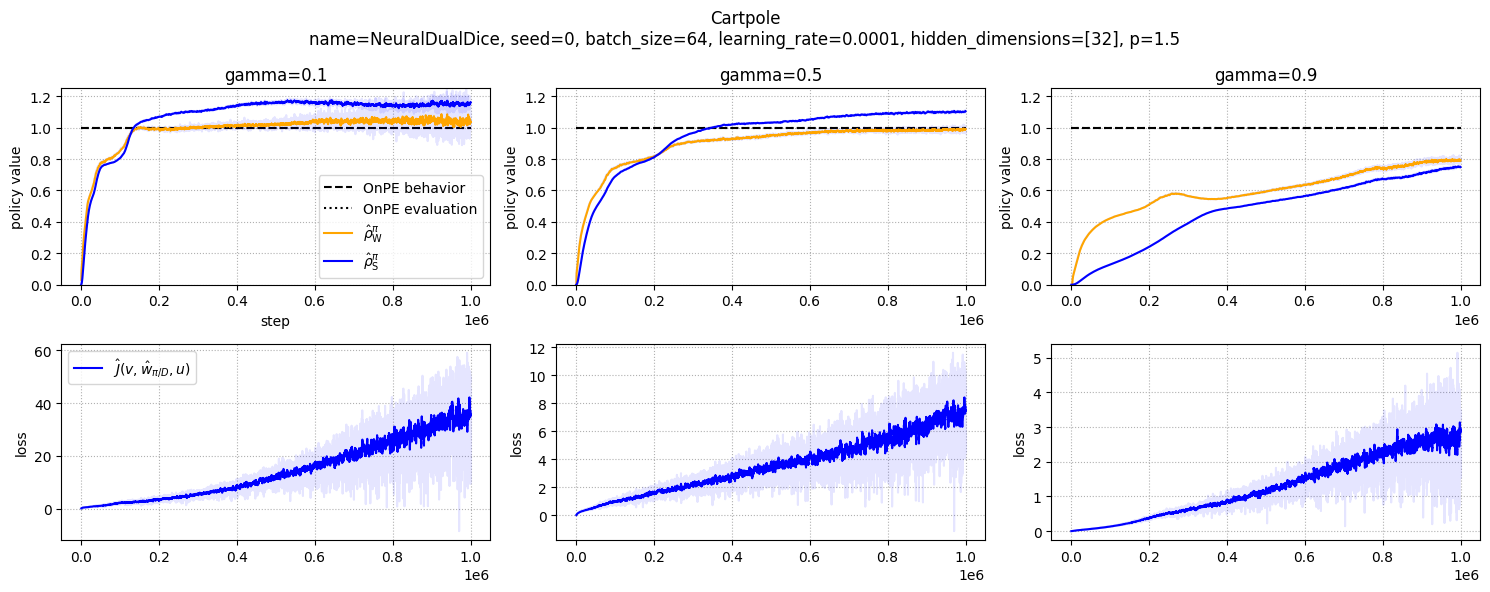

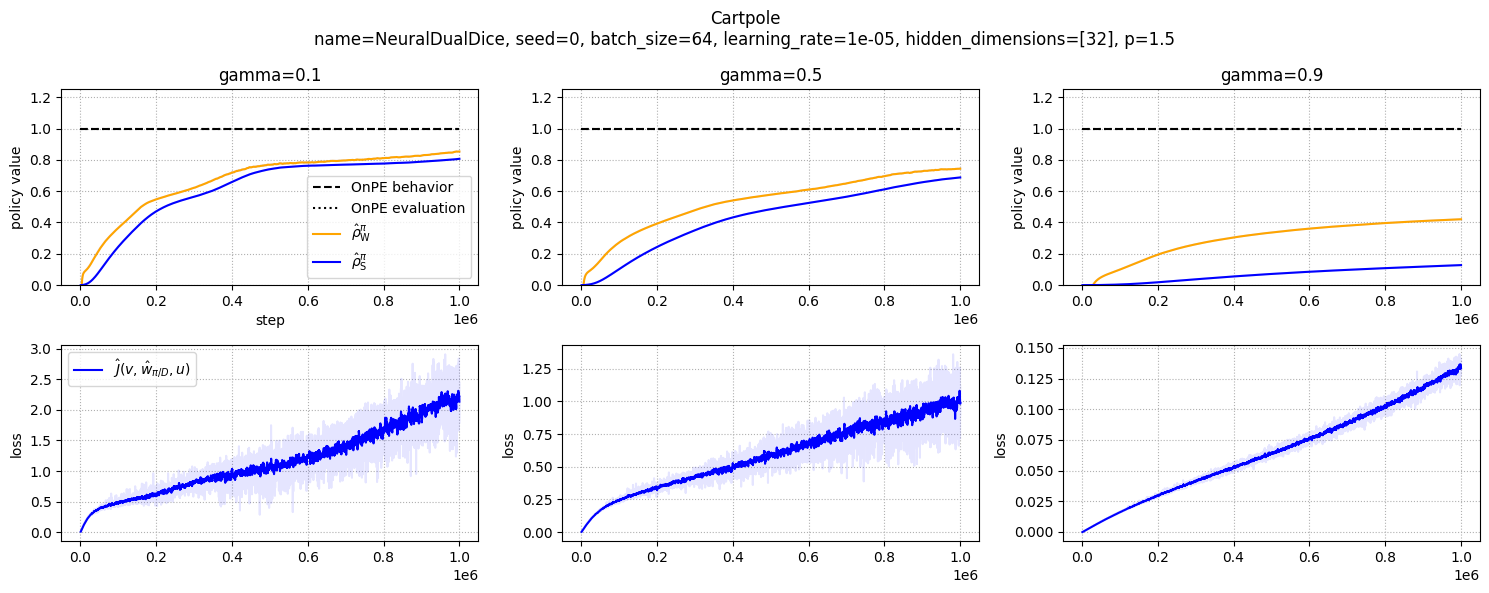

In [9]:
for learning_rate in learning_rates:
    get_logs_and_plot(
        get_policy_value=get_policy_value,
        hyperparameters_evaluation=[
            {
                "name": "NeuralDualDice",
                "gamma": gamma_,
                "seed": seed,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "hidden_dimensions": hidden_dimensions,
                "other": {
                    "p": p,
                    "id_policy": id_policy["evaluation"],
                },
            }
                for gamma_ in gammas
        ],
        hyperparameters_dict={
            "policy": {
                "seed": seed,
                "total_timesteps": total_timesteps["behavior"],
            },
            "dataset": {
                "seed": seed,
                "n_trajectories": n_trajectories,
                "max_episode_steps": max_episode_steps,
            },
        },
        ylims=3*[
            { "pv": (0, 1.25), }
        ],
        n_samples_moving_average=3*[
            merge_dicts(
                { "pv_s": n_ma, "pv_w": n_ma, },
                { "loss": n_ma, }
            )
        ],
        dir_save=dir_images,
    )

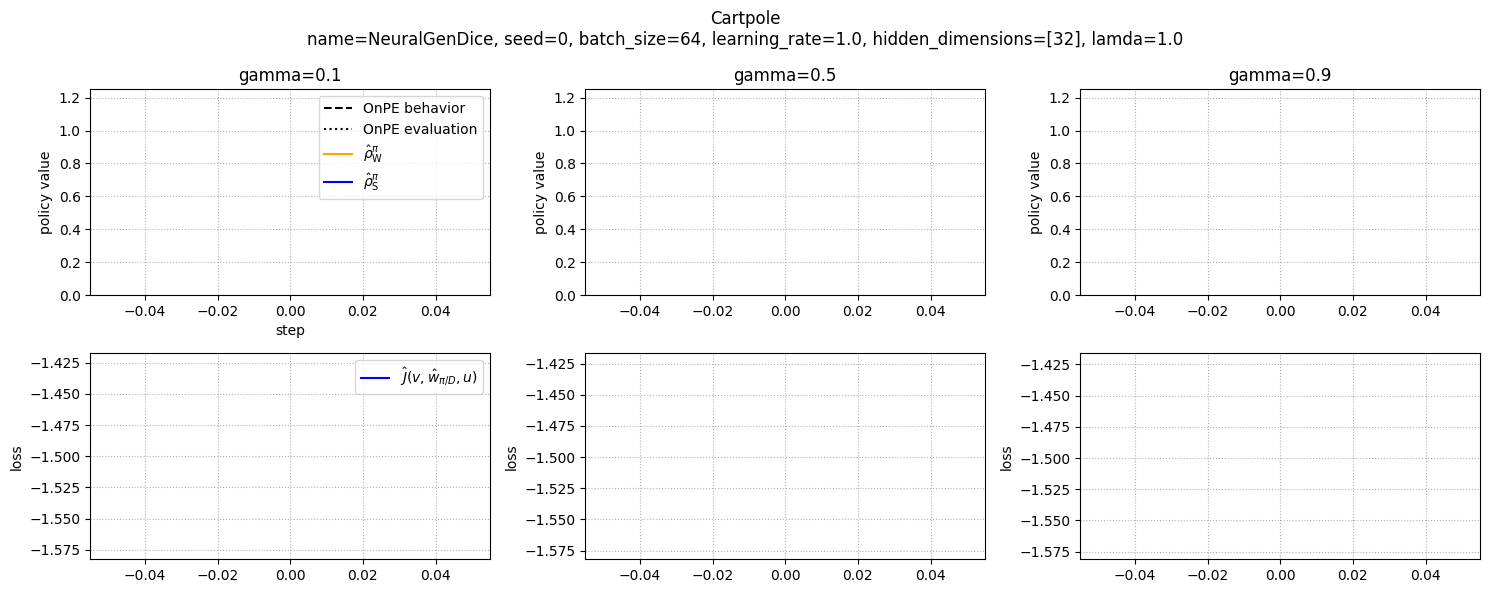

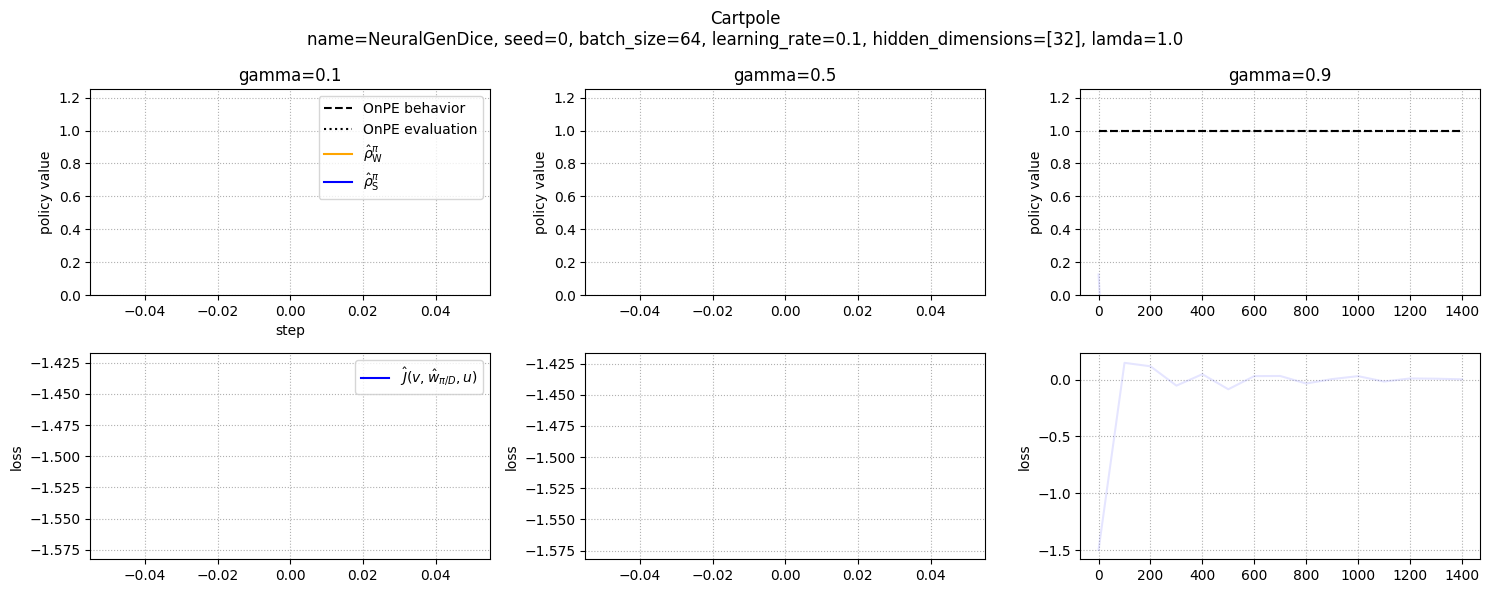

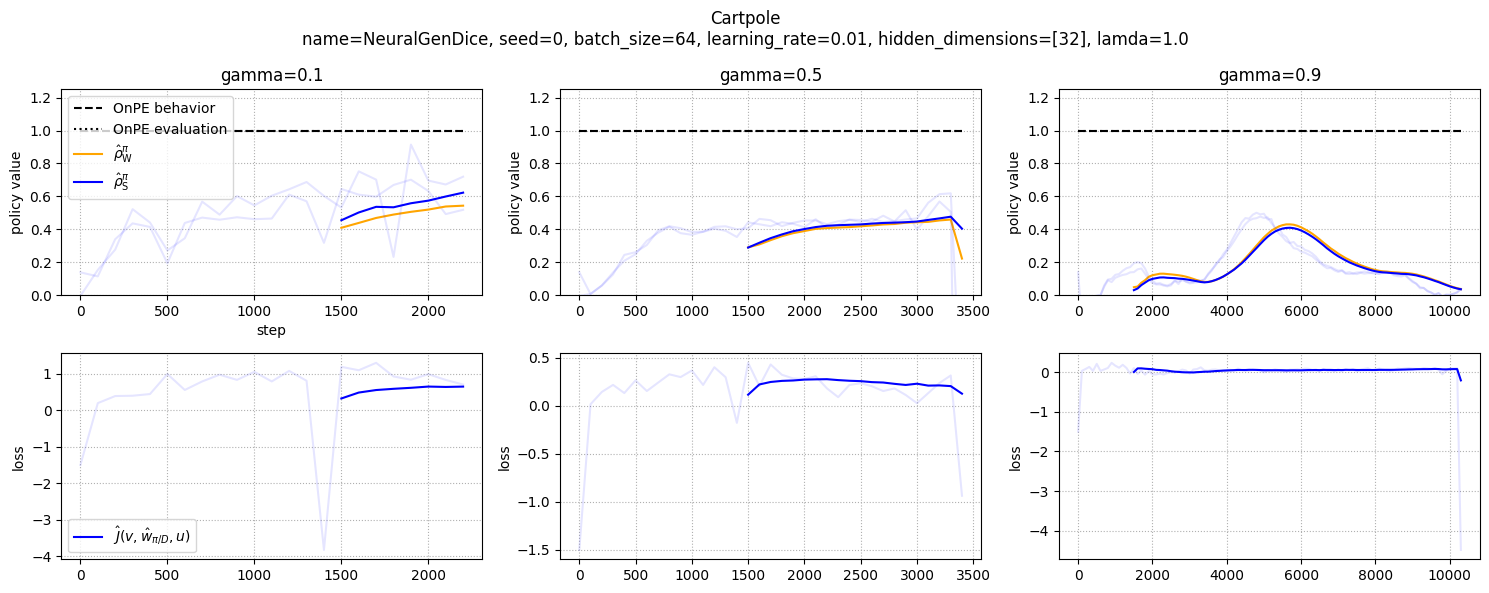

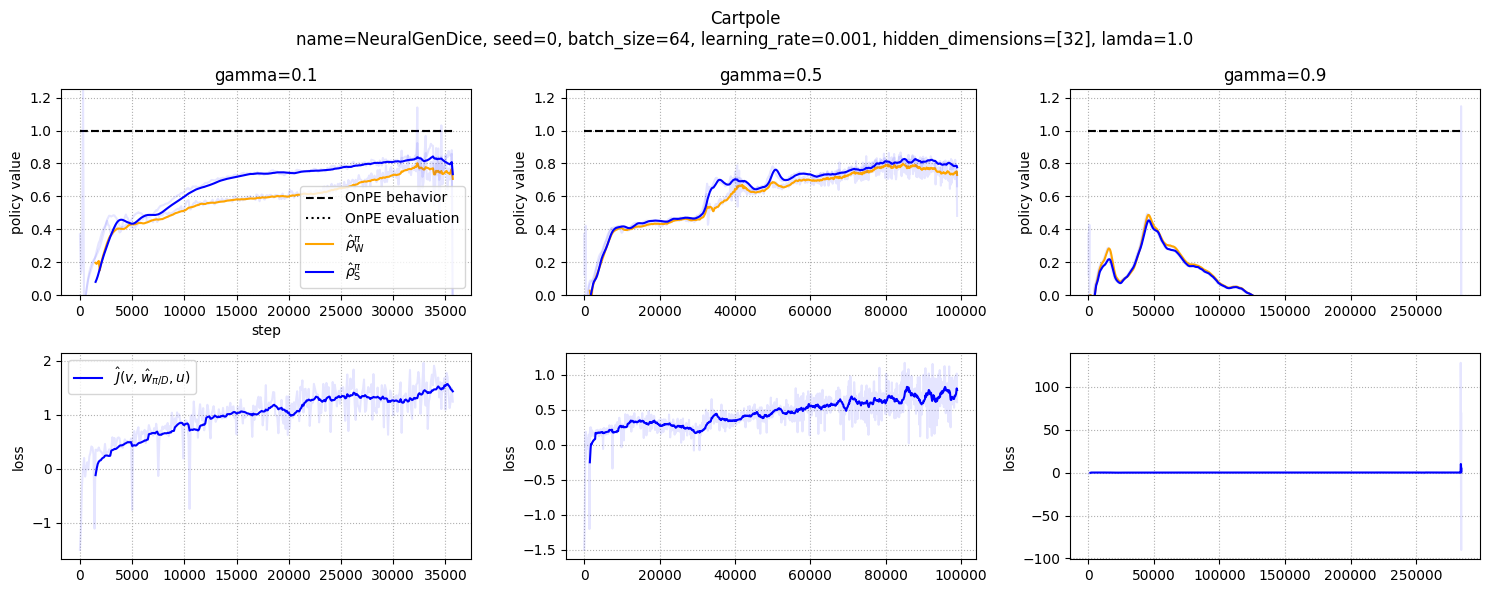

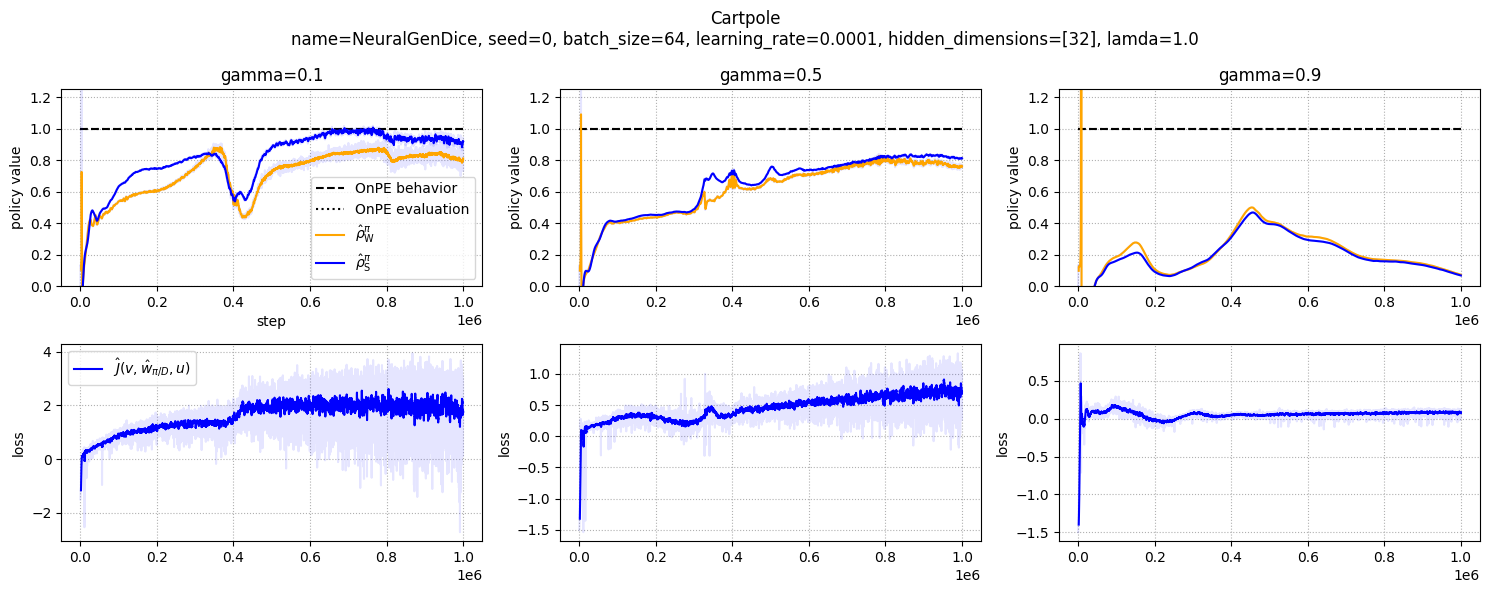

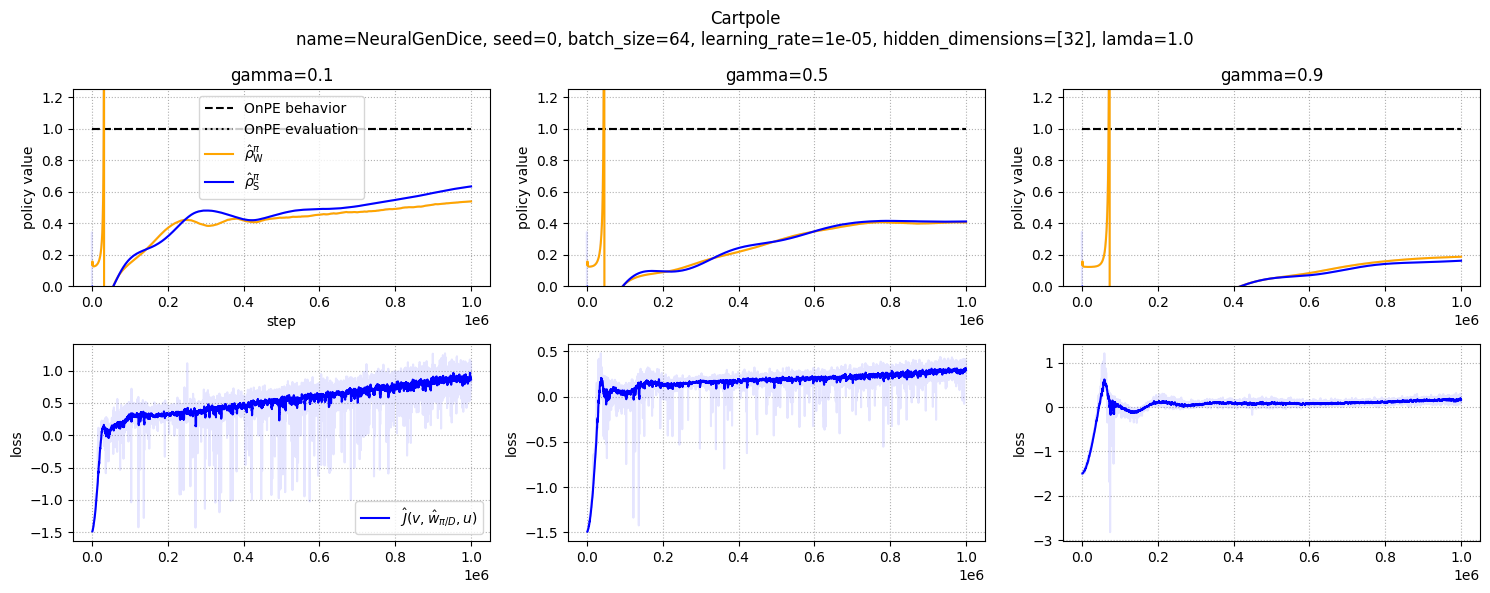

In [10]:
for learning_rate in learning_rates:
    get_logs_and_plot(
        get_policy_value=get_policy_value,
        hyperparameters_evaluation=[
            {
                "name": "NeuralGenDice",
                "gamma": gamma_,
                "seed": seed,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "hidden_dimensions": hidden_dimensions,
                "other": {
                    "lamda": lamda,
                    "id_policy": id_policy["evaluation"],
                },
            }
                for gamma_ in gammas
        ],
        hyperparameters_dict={
            "policy": {
                "seed": seed,
                "total_timesteps": total_timesteps["behavior"],
            },
            "dataset": {
                "seed": seed,
                "n_trajectories": n_trajectories,
                "max_episode_steps": max_episode_steps,
            },
        },
        ylims=3*[
            { "pv": (0, 1.25), }
        ],
        n_samples_moving_average=3*[
            merge_dicts(
                { "pv_s": n_ma, "pv_w": n_ma, },
                { "loss": n_ma, }
            )
        ],
        dir_save=dir_images,
    )

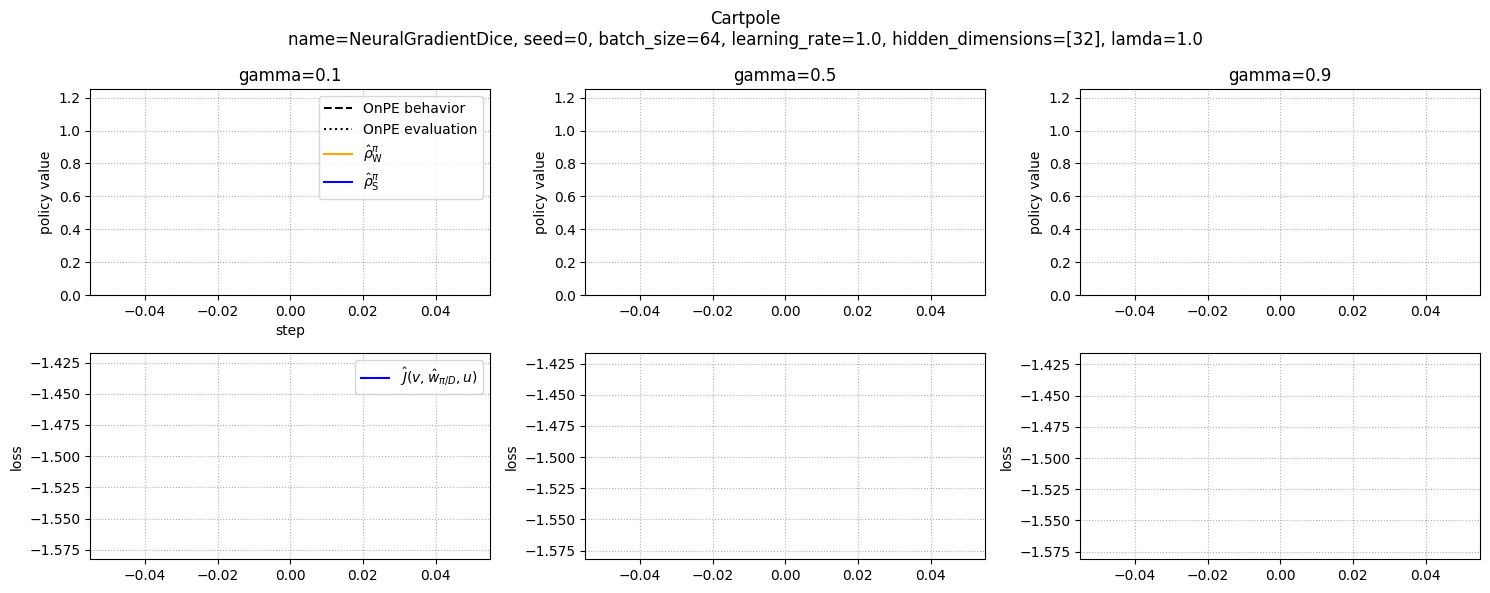

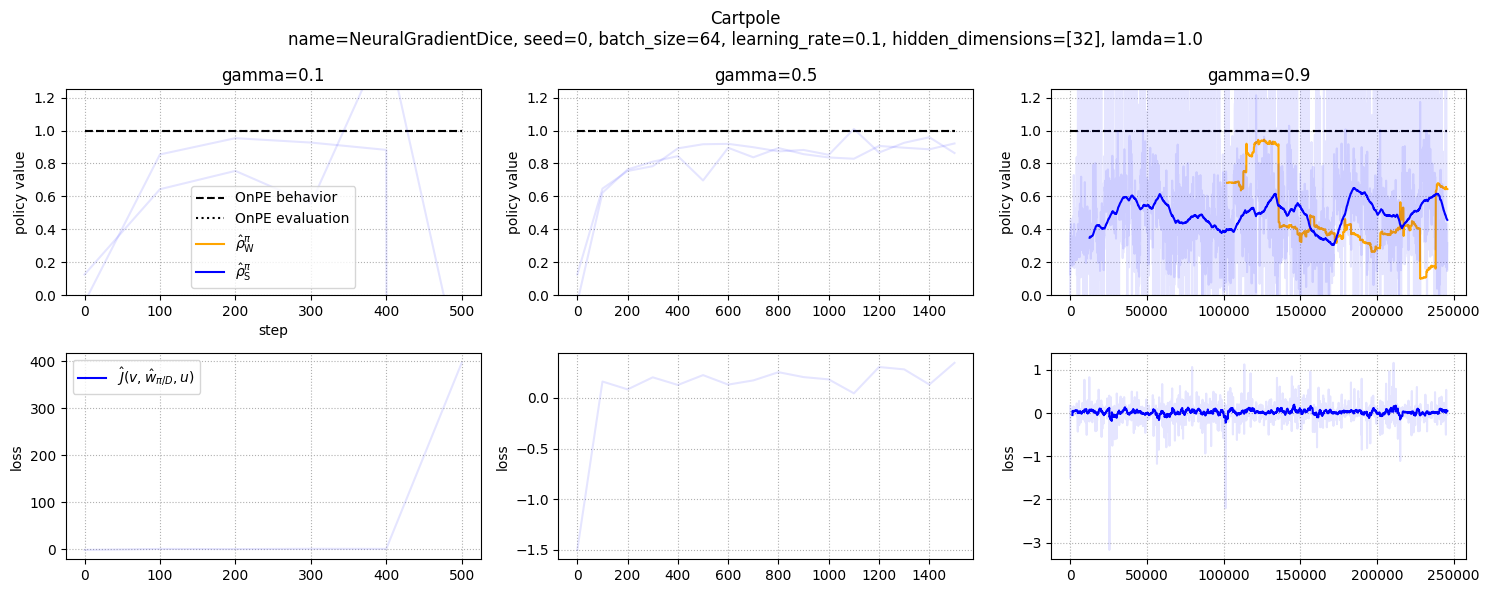

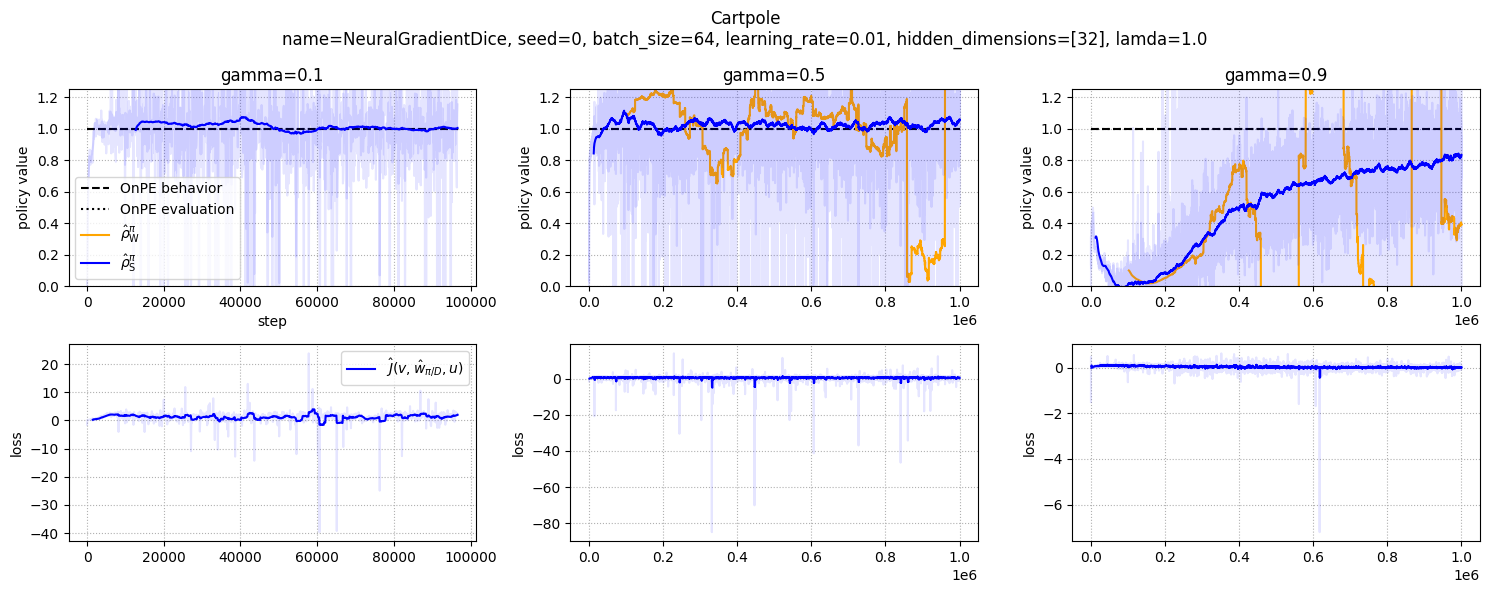

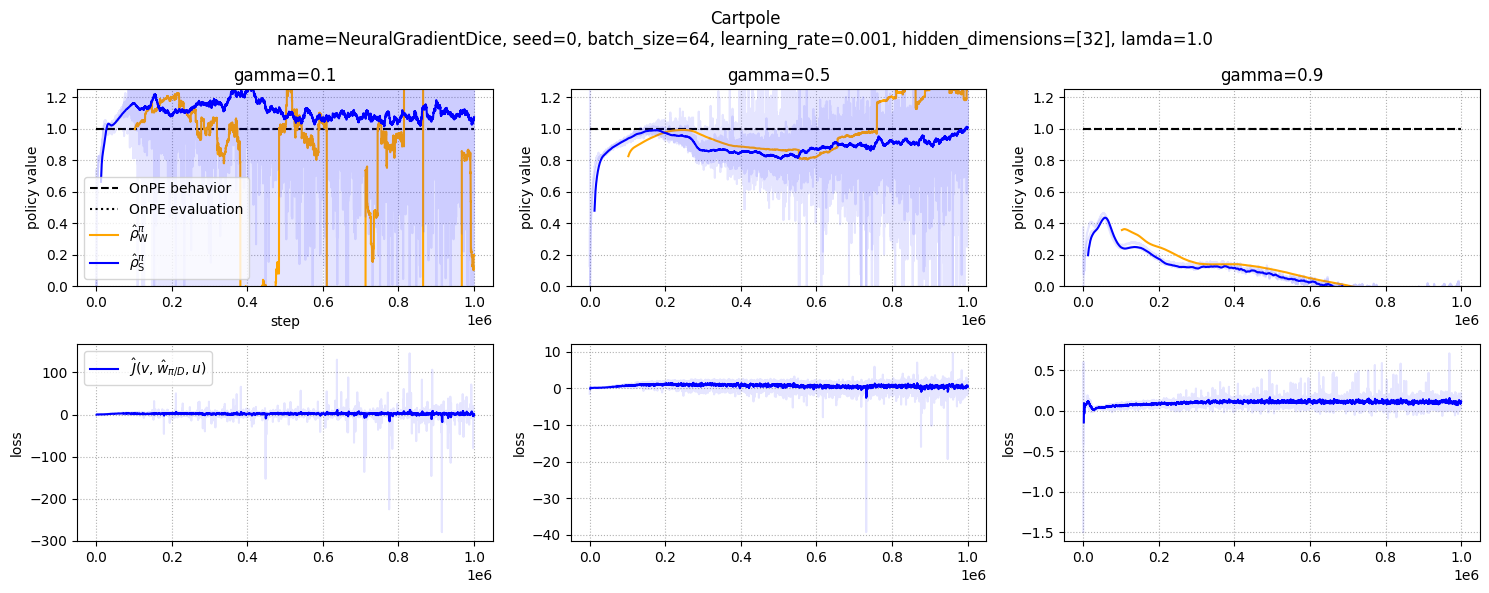

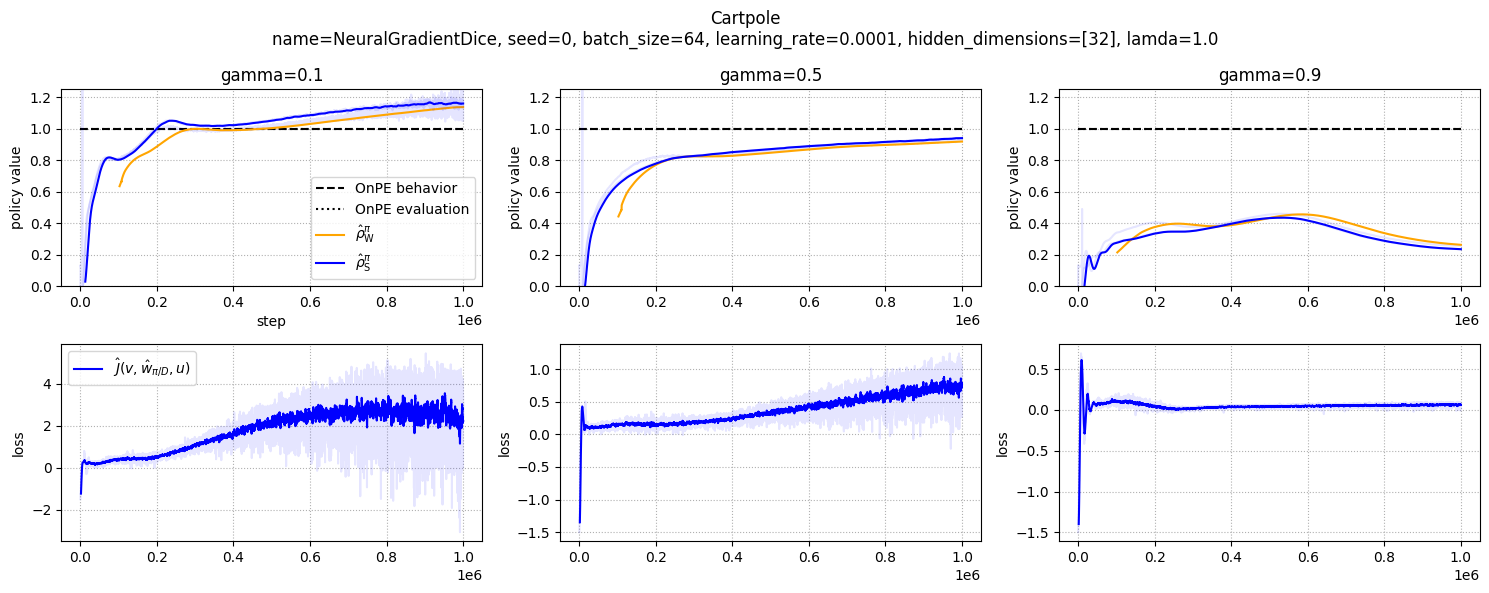

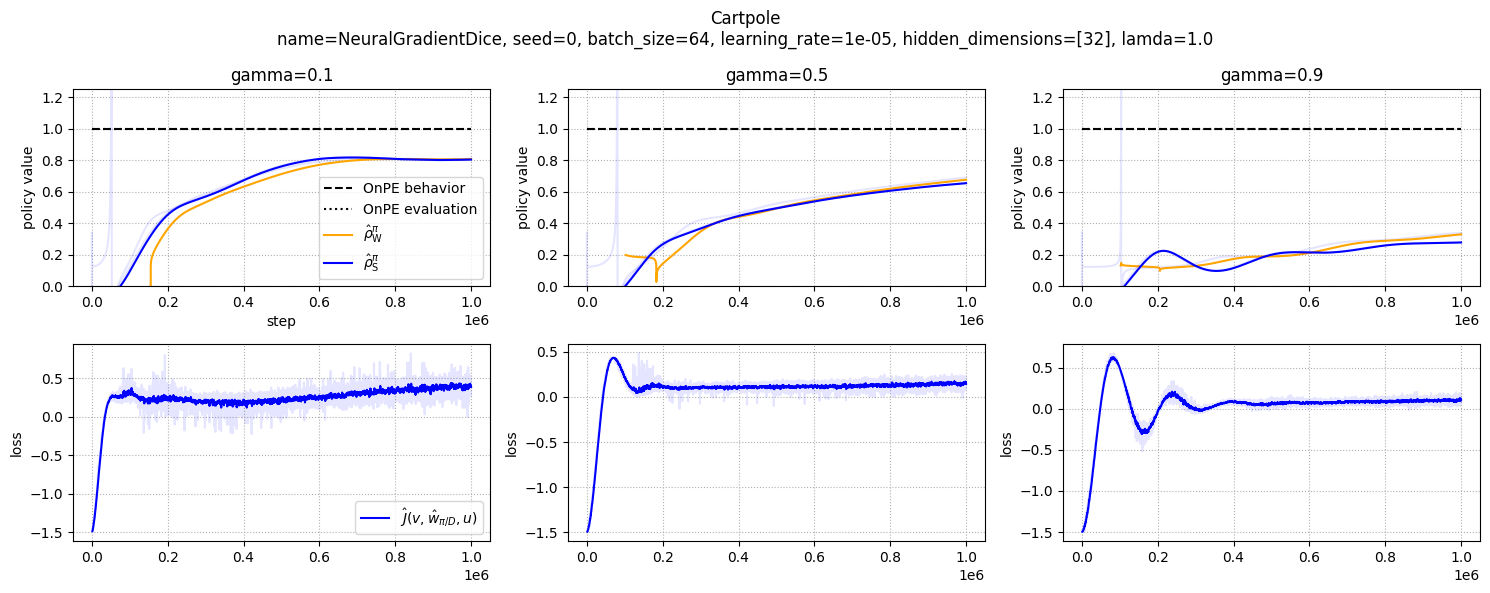

In [15]:
for learning_rate in learning_rates:
    get_logs_and_plot(
        get_policy_value=get_policy_value,
        hyperparameters_evaluation=[
            {
                "name": "NeuralGradientDice",
                "gamma": gamma_,
                "seed": seed,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "hidden_dimensions": hidden_dimensions,
                "other": {
                    "lamda": lamda,
                    "id_policy": id_policy["evaluation"],
                },
            }
                for gamma_ in gammas
        ],
        hyperparameters_dict={
            "policy": {
                "seed": seed,
                "total_timesteps": total_timesteps["behavior"],
            },
            "dataset": {
                "seed": seed,
                "n_trajectories": n_trajectories,
                "max_episode_steps": max_episode_steps,
            },
        },
        ylims=3*[
            { "pv": (0, 1.25), }
        ],
        n_samples_moving_average=3*[
            merge_dicts(
                { "pv_s": 128, "pv_w": 1024, },
                { "loss": n_ma, }
            )
        ],
        dir_save=dir_images,
    )